<a href="https://colab.research.google.com/github/hoangdungnguyen/XVA-stage/blob/master/Quantile_regression_tree_based_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random

from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist
print('GPU available: ',torch.cuda.is_available())
device = torch.device("cpu")

GPU available:  True


# 0 Some tool functions

In [0]:
def KMeans(x, K=10, Niter=20, verbose=False):
    x = x.to(device)
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[np.random.permutation(N)[:K], :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = c[None, :, :]  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torch.float)  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

# 1 Data simulator

In [0]:
class call_pricing_generator:

    def __init__(self, dim_X = 5, T = 1.5, r = 0.025, random_state = None) :
        self.dim_X = dim_X
        self.K = np.random.RandomState(random_state).uniform(80, 120, dim_X)
        self.T = T
        self.r = r
        self.sigma = np.random.RandomState(random_state).uniform(0.1,0.5, dim_X)
        self.omega = np.random.RandomState(random_state).uniform(0.,1., dim_X)
  
    def print_para(self):
        return {'dim_X': self.dim_X, 'K': self.K, 'T': self.T, 'r': self.r, 
                'sigma': self.sigma, 'omega': self.omega}

    def simulate(self, N_sim = 10000, random_state = None):
        payoff = np.zeros([N_sim, self.dim_X])
        price = np.zeros([N_sim, self.dim_X])
        S0 = np.zeros([N_sim, self.dim_X])
        for i in range(self.dim_X):
            S0[:,i] = np.random.RandomState(random_state).uniform(10+i*5, 180+i*5, N_sim)
            ST = S0[:,i]*np.exp((self.r-0.5*self.sigma[i]**2)*self.T+self.sigma[i]*np.sqrt(self.T)*np.random.normal(size=N_sim))
            payoff[:,i] = np.exp(-self.r*self.T)*np.maximum(ST-self.K[i], 0)
            d1 = (np.log(S0[:,i]/self.K[i])+(self.r+0.5*self.sigma[i]**2)*self.T)/(self.sigma[i]*np.sqrt(self.T))
            d2 = d1 - self.sigma[i]*np.sqrt(self.T)
            price[:,i] = S0[:,i]*norm.cdf(d1)-np.exp(-self.r*self.T)*self.K[i]*norm.cdf(d2)
            
        payoff = np.sum(payoff*self.omega, axis = 1)
        price = np.sum(price*self.omega, axis = 1)
        return (torch.from_numpy(S0.reshape(-1,self.dim_X)).type(torch.FloatTensor),
                torch.from_numpy(payoff.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(price.reshape(-1,1)).type(torch.FloatTensor))

In [0]:
class var_es_generator:

    def __init__(self, X_dim = 20, eps = 0.025, lambda_rs = 10, mu_rs = 20):
        self.X_dim = X_dim
        self.eps = eps
        self.lambda_rs = lambda_rs
        self.mu_rs = mu_rs
        
    
    def mean_X(self):
        return np.zeros(self.X_dim)
    
    def var_X(self):
        return np.identity(self.X_dim)

    def cond_mean_std_Y(self, X, weight_vector): 
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * weight_vector, axis = 1)
    
    def simulate(self, nb_simulation = 10000, lambda_0 = 10., mu_0 = 3.) :
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), nb_simulation)
        #lambda vector : P1(x) = lambda_0 + sum lambda_i*xi + sum lambda_ij*xi*xj
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(self.lambda_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        #mu vector : P2(x) = mu_0 + sum mu_i*xi + sum mu_ij*xi*xj
        self.mu_vector = np.append(mu_0, np.random.RandomState(self.mu_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        mean_Y = self.cond_mean_std_Y(X, self.lambda_vector)
        std_Y = self.cond_mean_std_Y(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(nb_simulation, self.X_dim)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)

In [0]:
test = var_es_generator(X_dim = 5)
X_train, Y_train, true_VaR, true_ES, mean_Y,_ = test.simulate(10000, lambda_0= 20, mu_0 = 10)

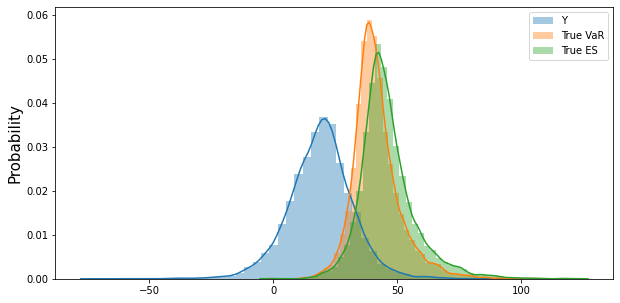

In [7]:
plt.figure(figsize=(10,5))
sns.distplot(Y_train.data, label='Y')
sns.distplot(true_VaR.data, label='True VaR')
sns.distplot(true_ES.data, label='True ES')
plt.title("", fontsize=12)
plt.xlabel("")
plt.ylabel("Probability", fontsize=15)
plt.legend()

# 2 Randomized layers

In [0]:
class Randomprojection:

    def __init__(self, Layers = [10, 100], random_state = None, activation = 'sigmoid'):

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(tdist.normal.Normal(0., 1.).sample((input_size, output_size)))
                self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(tdist.normal.Normal(0., 1.).sample((input_size, output_size)))
                torch.manual_seed(2*random_state+i)
                self.W.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = torch.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def fit_transform(self, X):
        X = X.to(device)
        for W,b in zip(self.W, self.b):
            X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        return X

In [0]:
class Autoencoder(nn.Module):

    def __init__(self, Layers = [1,20,40], activation = 'relu'):
        super(Autoencoder, self).__init__()
        self.hidden = nn.ModuleList()
        # Example: Encoder 1 - 20 - 40 and Decoder 40 - 20 - 1
        Layers = Layers + Layers[::-1]
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

    def forward_central_layer(self, x):
        x = x.to(device)
        L = int(len(self.hidden) / 2)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [0]:
class RBFlayer:
    """RBFlayer.
    Parameters
    ----------
    function: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.DoubleTensor)


    def fit(self, X):
        _, self.centroids = KMeans(X, self.K, 10)
          
    def transform(self, X):
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)


# 3 Readout layers

In [0]:
from sklearn.linear_model import LinearRegression

class LR_readout:
    
    def __init__(self, intercept = True, normalize=False):
        self.lin_reg = LinearRegression(fit_intercept=intercept, normalize=normalize, n_jobs=-1)

    def fit(self, X, y):
        self.lin_reg.fit(X.cpu(),y.cpu())
        self.coef = torch.tensor(self.lin_reg.coef_.T)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X.cpu())).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y):
        y = y.to(device)
        return torch.mean((self.predict(X) - y)**2)

In [0]:
class NN_nlayers(nn.Module):

    def __init__(self, Layers, activation = 'relu'):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [15]:
gc.collect()

694

In [0]:
sys_variables = sys.modules[__name__]

def data_simulator(dim_X = 50, eps = 0.025, nb_path = 50000):
    Var_Es_Generator = var_es_generator(X_dim=dim_X, eps = eps, lambda_rs = random.randint(0,2000), mu_rs= random.randint(0,2000))

    X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Var_Es_Generator.simulate(nb_path, lambda_0 = 10., mu_0 = 3.)
    X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Var_Es_Generator.simulate(nb_path, lambda_0 = 10., mu_0 = 3.)

    sys_variables.X_train = X_train.to(device)
    sys_variables.Y_train = Y_train.to(device)
    sys_variables.true_VaR_train = true_VaR_train.to(device)
    sys_variables.true_ES_train = true_ES_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.Y_test = Y_test.to(device)
    sys_variables.true_VaR_test = true_VaR_test.to(device)
    sys_variables.true_ES_test = true_ES_test.to(device)

    sys_variables.eps = eps
    sys_variables.dim_X = dim_X

In [0]:
data_simulator(dim_X = 50, eps = 0.025)

# 4 Quantile tree-based regression

### Random Forest Quantile Regressor

In [0]:
def NRMSE_numpy(pred, true, true_std):
    return np.sqrt(np.mean((pred - true)**2))/ true_std

def plot_function_numpy(var_test_pre, var_test_true, var_test_true_std):
    plt.figure(figsize=(8,6))

    g = sns.distplot(var_test_pre, label='predicted VaR')
    g = sns.distplot(var_test_true, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    print('NRMSE out-sample VaR: ',NRMSE_numpy(var_test_pre, var_test_true, var_test_true_std))


In [20]:
!pip install scikit-garden
from skgarden import RandomForestQuantileRegressor,ExtraTreesQuantileRegressor


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

In [21]:
p1 = time.time()

rfqr = RandomForestQuantileRegressor(min_samples_split=10, n_estimators=200, n_jobs =-1, max_depth =6,
                                     criterion = 'mse')
rfqr.fit(X_train.numpy(), Y_train.numpy())

print('\n Computation: ', time.time() - p1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning


 Computation:  157.83321022987366


NRMSE out-sample VaR:  1.2975874757322543
CPU times: user 8min 30s, sys: 3.62 s, total: 8min 33s
Wall time: 8min 34s


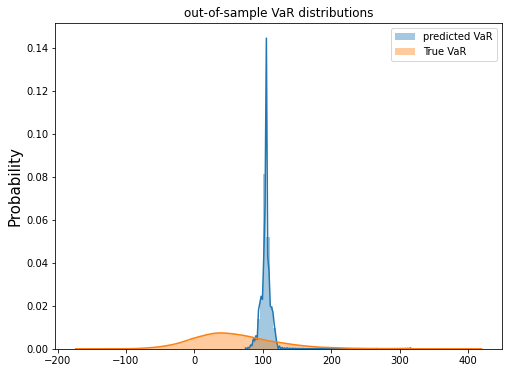

In [22]:
%%time
Var_pre = rfqr.predict(X_test[:10000].numpy(), quantile=97.5)
plot_function_numpy(Var_pre, true_VaR_test[:10000].numpy(), float(true_VaR_test.std()))

### Sklearn Gradient Boosting

In [0]:
gc.collect()
from sklearn.ensemble import GradientBoostingRegressor

skgb_quantile = GradientBoostingRegressor(loss='quantile', alpha=0.975,
                n_estimators=300, max_depth=6,
                learning_rate=0.1, min_samples_leaf=10,
                min_samples_split=10,verbose=20)

In [24]:
p1 = time.time()
skgb_quantile.fit(X_train.numpy(), Y_train.numpy().ravel())
Var_pre = skgb_quantile.predict(X_test[:10000].numpy())

print('\n ES Computation: ', time.time() - p1)

      Iter       Train Loss   Remaining Time 
         1           3.4246            9.49m
         2           3.4131            9.37m
         3           3.4035            9.35m
         4           3.3894            9.28m
         5           3.3758            9.22m
         6           3.3653            9.19m
         7           3.3527            9.14m
         8           3.3386            9.09m
         9           3.3305            9.06m
        10           3.3211            9.03m
        11           3.3129            9.01m
        12           3.3035            8.97m
        13           3.2900            8.94m
        14           3.2793            8.90m
        15           3.2728            8.88m
        16           3.2665            8.85m
        17           3.2579            8.81m
        18           3.2536            8.79m
        19           3.2451            8.76m
        20           3.2380            8.72m
        21           3.2324            8.69m
        2

NRMSE out-sample VaR:  1.1485205277303836


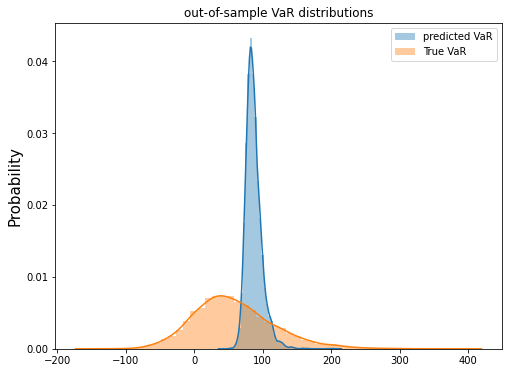

In [25]:
plot_function_numpy(Var_pre, true_VaR_test[:10000].numpy(), float(true_VaR_test.std()))

### Lightgbm

In [0]:
gc.collect()
import lightgbm as lgb

lgbm_quantile = lgb.LGBMRegressor(objective = 'quantile',
                            alpha = 0.975,
                            num_leaves = 10,
                            learning_rate = 0.1,
                            n_estimators = 1000,
                            max_depth = 6,
                            min_data = 500,)

In [27]:
p1 = time.time()
lgbm_quantile.fit(X_train.numpy(), Y_train.numpy().ravel())
Var_pre = lgbm_quantile.predict(X_test[:10000].numpy())
print('\n ES Computation: ', time.time() - p1)


 ES Computation:  8.989435911178589


NRMSE out-sample VaR:  1.1463634960322917


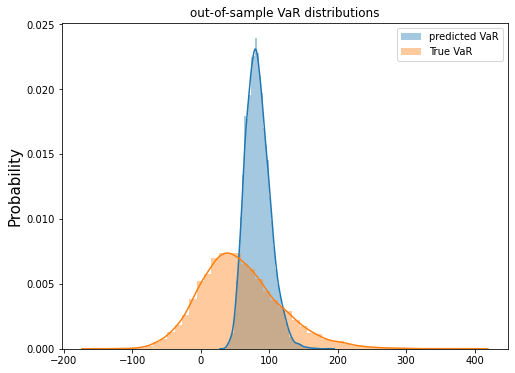

In [28]:

plot_function_numpy(Var_pre, true_VaR_test[:10000].numpy(), float(true_VaR_test.std()))

### Modified xgboost

In [0]:
gc.collect()
from xgboost.sklearn import XGBRegressor
#@title XGBQuantile Class
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

    
 

In [30]:
p1 = time.time()
xgb_quantile = XGBRegressor(n_estimators=300,max_depth=8,reg_alpha=5, reg_lambda=1,gamma=0.5,
                         quant_alpha=0.975)
xgb_quantile.fit(X_train.numpy(), Y_train.numpy().ravel())

print('\n Computation: ', time.time() - p1)

[12:15:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 Computation:  115.95409274101257


NRMSE out-sample VaR:  1.4361190146823026


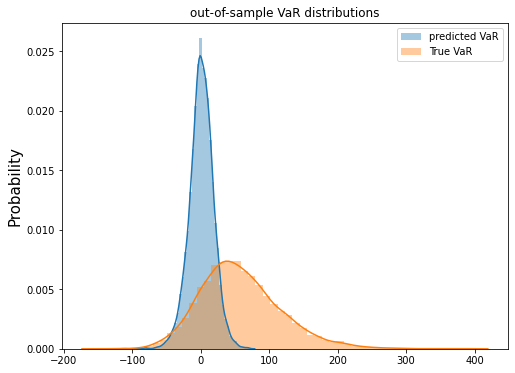

In [31]:
Var_pre = xgb_quantile.predict(X_test[0:10000].numpy())
plot_function_numpy(Var_pre, true_VaR_test[0:10000].numpy(), float(true_VaR_test.std()))